In [5]:
from graph_tool.all import *
import numpy as np
from re import search, sub
from textwrap import fill
from itertools import chain, groupby
from operator import itemgetter
from collections import defaultdict

In [6]:
PATH = "data\split-0.dag" #input graph data file
GRAPH_DATA = "data\graph.txt" #output grapg data file
STATS = "data\jobs.txt" #input stats file
EXTRACTED = "data\ex_stats.txt" #output stats file

In [7]:
def cut_graph_file(in_f, out_f):
    with open(in_f, 'r') as f:
        with open(out_f, 'w') as f2:
            for line in f:
                if line.startswith(('PARENT', 'CHILD')):
                    f2.write(line)
                    
def cut_stat_file(in_f, out_f):
    with open(in_f, 'r') as s:
        with open(out_f, 'w') as w:
            for l in s:
                if not l.startswith(('#', 'Job')):
                    w.write(l)
                    
cut_stat_file(STATS, EXTRACTED)          
cut_graph_file(PATH, GRAPH_DATA)

In [8]:
def remove_data(graph_set):
    graph_set.remove('PARENT')
    graph_set.remove('CHILD')
    return graph_set

def create_empty_matrix():
    graph_set = set()
    with open(GRAPH_DATA, 'r') as f:
        for line in f:
            data = line.split()
            graph_set.update(data)
    graph_set = remove_data(graph_set)
    sez_size = len(graph_set)
    return np.zeros((sez_size, sez_size)), graph_set

In [9]:
def unique_dict_entry(graph_set):
    return {v:k for k, v in enumerate(graph_set)}

def create_adjacency_matrix(adjacency_matrix, dict_data):
    with open(GRAPH_DATA, 'r') as f:
        for line in f:
            parent = search(r'(?<=\bPARENT\s)(\s+\w+)', line).group()
            child = search(r'(?<=\bCHILD)(\s+\w+)', line).group()
            parent_id = dict_data.get(parent.strip())
            child_id = dict_data.get(child.strip())
            matrix[parent_id][child_id] = 1
    return adjacency_matrix

In [10]:
JOB_NAME = 0
REAL_TIME = 3
CPU_TIME = 6
def parse_stat_file(in_f):
    data = {}
    with open(in_f, 'r') as s:
        for l in s:
            d = l.split()
            try:
                data[d[JOB_NAME]] = [d[REAL_TIME], d[CPU_TIME]]
            except IndexError:
                print("Cannot retrive some data")
    return data

stats_data = parse_stat_file(EXTRACTED)

Cannot retrive some data


In [11]:
matrix, data = create_empty_matrix()
data_d = unique_dict_entry(data)
a_matrix = create_adjacency_matrix(matrix, data_d)

In [12]:
print(a_matrix)

[[ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.]]


In [14]:
def merge_graph_data(graph_data, stats_data):
    chained = defaultdict(list)
    for k, v in chain(graph_data.items(), stats_data.items()):
        chained[k].append(v)
    return chained

chained_data = merge_graph_data(data_d, stats_data)

In [15]:
chained_data

defaultdict(list,
            {'clean_up_local_level_3_0': [1, ['2.261', '0.083']],
             'clean_up_local_level_4_0': [8, ['8.088', '0.104']],
             'clean_up_local_level_5_0': [9, ['8.087', '0.113']],
             'cleanup_split_0_local': [11, ['2.0', '-']],
             'create_dir_split_0_local': [2, ['2.0', '-']],
             'register_local_1_0': [7, ['0.217', '0.214']],
             'split_ID0000001': [10, ['0.002', '0.001']],
             'stage_in_remote_local_0_0': [3, ['2.1', '0.093']],
             'stage_out_local_local_1_0': [4, ['4.089', '0.114']],
             'wc_ID0000002': [0, ['0.003', '0.0']],
             'wc_ID0000003': [5, ['0.0', '0.0']],
             'wc_ID0000004': [12, ['0.0', '0.0']],
             'wc_ID0000005': [6, ['0.001', '0.001']]})

In [79]:
g = Graph()
from os import linesep
def shorten_label(label):
    components = label.replace('0', "").split('_')
    
    return components[0] + "".join(x.title() for x in components[1:])

def transform_dict(data_dict, graph):
    transformed_dict = {}
    for key, val in data_dict.items():
        transformed_dict[val[0]] = {'name': shorten_label(key),
                                    'full_name': key,
                                    'vertex': graph.add_vertex(),
                                    'exec_time': val[1][0],
                                    'cpu_time': val[1][1]}
    return transformed_dict

vertex_dict = transform_dict(chained_data, g)

In [80]:
vertex_dict.__str__()

"{0: {'name': 'wcId2', 'full_name': 'wc_ID0000002', 'vertex': <Vertex object with index '0' at 0x7fe8ebb748d0>, 'exec_time': '0.003', 'cpu_time': '0.0'}, 1: {'name': 'cleanUpLocalLevel3', 'full_name': 'clean_up_local_level_3_0', 'vertex': <Vertex object with index '1' at 0x7fe8ebb74330>, 'exec_time': '2.261', 'cpu_time': '0.083'}, 2: {'name': 'createDirSplitLocal', 'full_name': 'create_dir_split_0_local', 'vertex': <Vertex object with index '2' at 0x7fe8ebb74570>, 'exec_time': '2.0', 'cpu_time': '-'}, 3: {'name': 'stageInRemoteLocal', 'full_name': 'stage_in_remote_local_0_0', 'vertex': <Vertex object with index '3' at 0x7fe8ebb74510>, 'exec_time': '2.1', 'cpu_time': '0.093'}, 4: {'name': 'stageOutLocalLocal1', 'full_name': 'stage_out_local_local_1_0', 'vertex': <Vertex object with index '4' at 0x7fe8ebb74f30>, 'exec_time': '4.089', 'cpu_time': '0.114'}, 5: {'name': 'wcId3', 'full_name': 'wc_ID0000003', 'vertex': <Vertex object with index '5' at 0x7fe8ebb74690>, 'exec_time': '0.0', 'cpu

In [81]:
def s_n(string):
    return sub(r'\d+|_+', '', string)

def dict_to_set(dict_list):
    v = set()
    for dictx in dict_list:
        v.add(dictx['name'])
    return v
    
d_gr = [{'name': k, 'gr_name': s_n(k)} for k in data]

In [82]:
sorted_d_gr = sorted(d_gr, key=itemgetter('gr_name'))
groups = {}
index = 0
for _, v in groupby(sorted_d_gr, key=lambda x: x['gr_name']):
    groups[index] = dict_to_set(list(v))
    index += 1

In [83]:
def gr_num(vertex_name):
    for k, v in groups.items():
        if vertex_name in v:
            return k
    raise ValueError

In [84]:
from random import randint as ri
from random import random as ro
def create_color_dict():
    def _color():
        return (round(ro(),3), round(ro(),3), round(ro(),3), round(ro(),2))
    colors = {}
    for i in range(len(groups)):
        colors[i] = _color()
    return colors

gr_colors = create_color_dict()

In [85]:
def fill_graph(data_dict, a_matrix, graph):
    size = a_matrix.shape[0]
    vprop = graph.new_vertex_property("string")
    vgroup = graph.new_vertex_property("int")
    vcolor = graph.new_vertex_property("vector<double>")
    graph.vp.name = vprop
    graph.vp.groups = vgroup 
    graph.vp.colors = vcolor
    try:
        for i in range(size):
            act_ver = data_dict[i]['vertex']
            group_num = gr_num(data_dict[i]['full_name'])
            graph.vp.name[act_ver] = data_dict[i]['name']
            graph.vp.groups[act_ver] = group_num
            graph.vp.colors[act_ver] = gr_colors[group_num]
            for j in range(size):
                if a_matrix[i][j] == 1:
                    g.add_edge(act_ver, data_dict[j]['vertex'])
    except KeyError as e:
        print(e)

fill_graph(vertex_dict, a_matrix, g)

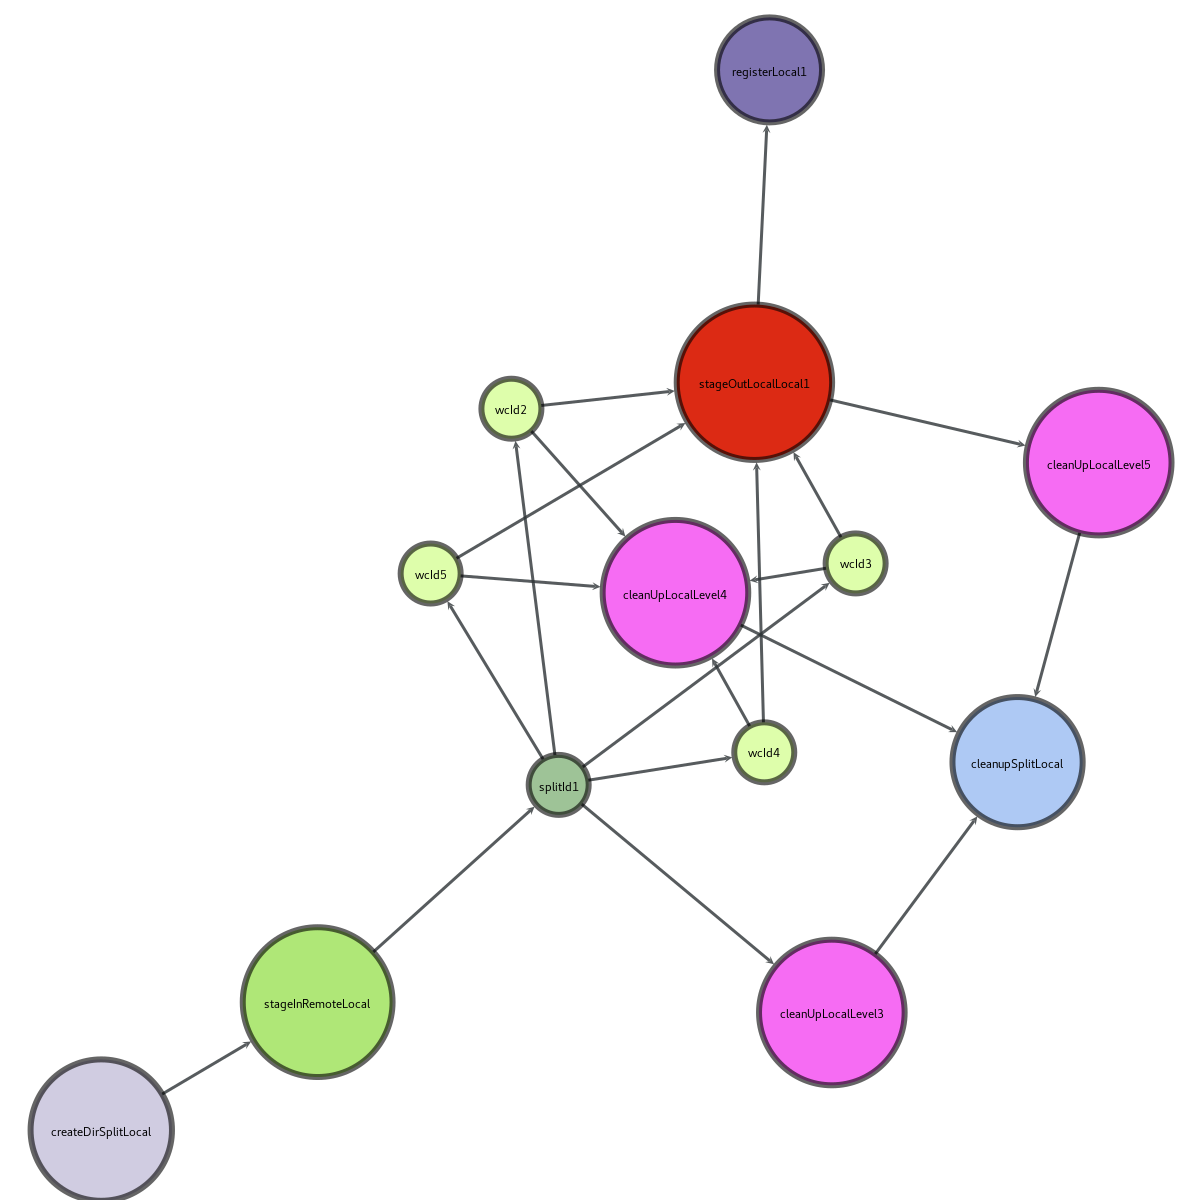

In [86]:
IMG_SIZE = (1200,1200)
VERTEX_SIZE = 60
EDGE_SIZE = 3
FONT_SIZE = 12
FONT_COLOR = (0,0,0,1)
def draw_graph(graph):
    pos = sfdp_layout(graph, groups=graph.vp.groups)
    graph_draw(graph, 
               pos=pos,
               vertex_text=graph.vp.name,
               vertex_fill_color=graph.vp.colors,
               vertex_color=(0,0,0,0.6),
               vertex_font_size=FONT_SIZE,
               vertex_size=VERTEX_SIZE,
               vertex_text_color=FONT_COLOR,
               edge_pen_width=EDGE_SIZE,
               output_size=IMG_SIZE,
               output="graph.png")
    
draw_graph(g)